In this tutorial, we will introduce how to implement a Principal Component Analysis Autoencoder (PCAAE).

First of all, we import libraries

In [85]:
%%capture
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from skimage.draw import ellipse
from skimage.io import imsave
from skimage.filters import gaussian
from skimage import img_as_uint

import torchvision
import torch
from torch import nn

from torch import optim
import itertools

Get some parametres

In [86]:
np.random.seed(0) 
image_size = 64
num_train_image = 256*50
num_test_image = 256*10
max_gray = 255.

save_training_image = False
path_data = 'dataset'

batchsize = 512
gpu = True
is_training = True
folder4weights = 'weights'
train_latent = 3
lambdacov = 1
lambdarec = 1
num_epoch = 100
lr = 0.001

if gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

We will create a dataset of grayscale ellipse images

In [87]:
def generating_data(num_image,image_size=64,max_gray=255,save_training_image=False,path_data='.'):
    # Random set of radius and rotation coefficients
    set_radius_x = np.random.randint(image_size/16, image_size/2, size=num_image)
    set_radius_y = np.random.randint(image_size/16, image_size/2, size=num_image)
    set_rotation = np.random.randint(0, 90, size=num_image)
    
    if save_training_image:
        if not os.path.exists(path_data):
            os.makedirs(path_data)

    list_image = []    

    for n_image in range(num_image):
        img = np.zeros((image_size, image_size), dtype=np.uint8)
        radius_x = set_radius_x[n_image]
        radius_y = set_radius_y[n_image]
        rotation = set_rotation[n_image]

        rr, cc = ellipse(image_size/2, image_size/2, radius_x, radius_y, rotation=np.deg2rad(rotation))
        img[rr, cc] = max_gray
        img = gaussian(img, sigma=0.5, preserve_range=True)

        if save_training_image:
            imsave(path_data+'/ellipse_'+str(n_image)+'.png', img_as_uint(img))

        list_image.append(np.expand_dims(np.expand_dims(img,0),0))

    list_image = np.concatenate(list_image,0)
    return list_image
                    
train_images =  generating_data(num_train_image,image_size=image_size,max_gray=max_gray,save_training_image=False,path_data=path_data)
test_images =  generating_data(num_test_image,image_size=image_size,max_gray=max_gray)

Verify our dataset

In [88]:
print(train_images.shape)
print(np.min(train_images),np.max(train_images))

(12800, 1, 64, 64)
0.0 255.0


Our dataset into GPU

In [89]:
train_dataset = torch.stack([torch.Tensor(i) for i in train_images])/ max_gray
test_dataset = torch.stack([torch.Tensor(i) for i in test_images])/ max_gray
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batchsize,num_workers=8,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)

Create the networks: encoder and decoder

In [90]:
import math
from numbers import Number

import torch
from torch.distributions import Distribution, constraints
from torch.distributions.utils import broadcast_all

CONST_SQRT_2 = math.sqrt(2)
CONST_INV_SQRT_2PI = 1 / math.sqrt(2 * math.pi)
CONST_INV_SQRT_2 = 1 / math.sqrt(2)
CONST_LOG_INV_SQRT_2PI = math.log(CONST_INV_SQRT_2PI)
CONST_LOG_SQRT_2PI_E = 0.5 * math.log(2 * math.pi * math.e)


class TruncatedStandardNormal(Distribution):
    """
    Truncated Standard Normal distribution
    https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'a': constraints.real,
        'b': constraints.real,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, a, b, eps=1e-8, validate_args=None):
        self.a, self.b = broadcast_all(a, b)
        if isinstance(a, Number) and isinstance(b, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.a.size()
        super(TruncatedStandardNormal, self).__init__(batch_shape, validate_args=validate_args)
        if self.a.dtype != self.b.dtype:
            raise ValueError('Truncation bounds types are different')
        if any((self.a >= self.b).view(-1,).tolist()):
            raise ValueError('Incorrect truncation range')
        self._dtype_min_gt_0 = torch.tensor(torch.finfo(self.a.dtype).eps, dtype=self.a.dtype)
        self._dtype_max_lt_1 = torch.tensor(1 - torch.finfo(self.a.dtype).eps, dtype=self.a.dtype)
        self._little_phi_a = self._little_phi(self.a)
        self._little_phi_b = self._little_phi(self.b)
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)
        self._log_Z = self._Z.log()
        self._lpbb_m_lpaa_d_Z = (self._little_phi_b * self.b - self._little_phi_a * self.a) / self._Z
        self._mean = -(self._little_phi_b - self._little_phi_a) / self._Z
        self._variance = 1 - self._lpbb_m_lpaa_d_Z - ((self._little_phi_b - self._little_phi_a) / self._Z) ** 2
        self._entropy = CONST_LOG_SQRT_2PI_E + self._log_Z - 0.5 * self._lpbb_m_lpaa_d_Z

    @property
    def mean(self):
        return self._mean

    @property
    def variance(self):
        return self._variance

    @property
    def entropy(self):
        return self._entropy

    @property
    def auc(self):
        return self._Z

    @staticmethod
    def _little_phi(x):
        return (-(x ** 2) * 0.5).exp() * CONST_INV_SQRT_2PI

    @staticmethod
    def _big_phi(x):
        return 0.5 * (1 + (x * CONST_INV_SQRT_2).erf())

    @staticmethod
    def _inv_big_phi(x):
        return CONST_SQRT_2 * (2 * x - 1).erfinv()

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((self._big_phi(value) - self._big_phi_a) / self._Z).clamp(0, 1)

    def icdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return self._inv_big_phi(self._big_phi_a + value * self._Z)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return CONST_LOG_INV_SQRT_2PI - self._log_Z - (value ** 2) * 0.5

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        p = torch.empty(shape).uniform_(self._dtype_min_gt_0, self._dtype_max_lt_1)
        return self.icdf(p)

    def expand(self, batch_shape, _instance=None):
        # TODO: it is likely that keeping temporary variables in private attributes violates the logic of this method
        raise NotImplementedError


class TruncatedNormal(TruncatedStandardNormal):
    """
    Truncated Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'loc': constraints.real,
        'scale': constraints.positive,
        'a': constraints.real,
        'b': constraints.real,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, loc, scale, a, b, eps=1e-8, validate_args=None):
        self.loc, self.scale, self.a, self.b = broadcast_all(loc, scale, a, b)
        a_standard = (a - self.loc) / self.scale
        b_standard = (b - self.loc) / self.scale
        super(TruncatedNormal, self).__init__(a_standard, b_standard, eps=eps, validate_args=validate_args)
        self._log_scale = self.scale.log()
        self._mean = self._mean * self.scale + self.loc
        self._variance = self._variance * self.scale ** 2
        self._entropy += self._log_scale

    def _to_std_rv(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return (value - self.loc) / self.scale

    def _from_std_rv(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return value * self.scale + self.loc

    def cdf(self, value):
        return super(TruncatedNormal, self).cdf(self._to_std_rv(value))

    def icdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return self._from_std_rv(super(TruncatedNormal, self).icdf(value))

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return super(TruncatedNormal, self).log_prob(self._to_std_rv(value)) - self._log_scale


In [91]:
def truncated_normal(loc=0., scale=1., a=-1., b = 1.):
    return TruncatedNormal(loc, scale, a, b)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        #print("Initialisation with truncated normal !")
        truncated_normal(m.weight)
        m.bias.data.fill_(0)

class Encoder(nn.Module):
    def __init__(self, code_size=1, kernel_size = 4, n_chan = 1):
        super(Encoder, self).__init__()        
        self.latent_dim = code_size
        
        # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(n_chan, int(code_size*32), kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(int(code_size*32), int(code_size*16), kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(int(code_size*16), int(code_size*8), kernel_size, **cnn_kwargs)
        self.conv4 = nn.Conv2d(int(code_size*8), int(code_size*4), kernel_size, **cnn_kwargs)
        self.conv5 = nn.Conv2d(int(code_size*4), int(code_size*2), kernel_size, **cnn_kwargs)
        self.conv6 = nn.Conv2d(int(code_size*2), code_size, kernel_size, **cnn_kwargs)
        self.zero_mean = nn.BatchNorm1d(self.latent_dim, affine=False, eps=0)
        self.leaky = nn.LeakyReLU(0.2)
    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with ReLu activations
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        x = self.leaky(self.conv3(x))
        x = self.leaky(self.conv4(x))
        x = self.leaky(self.conv5(x))
        x = self.conv6(x)
        z = x.view((batch_size, -1))
        z = self.zero_mean(z)
        return z  
    
class Decoder(nn.Module):
    def __init__(self, code_size=1, kernel_size = 4, n_chan = 1):
        super(Decoder, self).__init__()
        # Shape required to start transpose convs
        self.reshape = (code_size, 1, 1)
         
            # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        self.convT6 = nn.ConvTranspose2d(code_size, int(code_size*2), kernel_size, **cnn_kwargs)
        self.convT5 = nn.ConvTranspose2d(int(code_size*2), int(code_size*4), kernel_size, **cnn_kwargs)
        self.convT4 = nn.ConvTranspose2d(int(code_size*4), int(code_size*8), kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(int(code_size*8), int(code_size*16), kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(int(code_size*16), int(code_size*32), kernel_size, **cnn_kwargs)
        self.convT1 = nn.ConvTranspose2d(int(code_size*32), n_chan, kernel_size, **cnn_kwargs)
        self.leaky = nn.LeakyReLU(0.2)
        
    def forward(self, z):
        batch_size = z.size(0)
        x = z.view(batch_size, *self.reshape)
        
        # Convolutional layers with ReLu activations
        x = self.leaky(self.convT6(x))
        x = self.leaky(self.convT5(x))
        x = self.leaky(self.convT4(x))
        x = self.leaky(self.convT3(x))
        x = self.leaky(self.convT2(x))
        # Sigmoid activation for final conv layer
        x = nn.Sigmoid()(self.convT1(x))

        return x

Reconstruction loss

In [92]:
def reconstruction_loss(data, recon_data, MSE=False):
    if MSE:
        return nn.MSELoss()(data,recon_data)
    else:
        return nn.BCELoss()(data,recon_data)

Train a vanilla autoencoder

In [103]:
def train_AE(E,D, optimizer, epoch,  train_loader, device):
    train_loss = 0      
    test_loss = 0
    
    E.train()
    D.train()
    
    for batch_idx, (data) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z = E(data)          
        recon_data = D(z)
        loss = reconstruction_loss(recon_data, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    E.eval()
    D.eval()
    for batch_idx, (data) in enumerate(test_loader):
        data = data.to(device)  
        recon_data = D(E(data))
        loss = reconstruction_loss(recon_data, data)
        test_loss += loss.item()
        
    print('====> AE Epoch: {}, Train loss: {:.6f}, Test loss: {:.6f}'
          .format(epoch, train_loss / len(train_dataset), test_loss / len(test_dataset)))

In [104]:
AE_E = Encoder(code_size=train_latent).to(device)
AE_D = Decoder(code_size=train_latent).to(device)
AE_E.apply(init_weights)
AE_D.apply(init_weights)
AE_optim = optim.Adam(itertools.chain(AE_E.parameters(),AE_D.parameters()), lr=lr, betas=(0.5, 0.999))

if is_training:
    print("Training AE for ellipses")
    weightname = folder4weights+'/AE_ellipses'
    for epoch in range(1, num_epoch + 1):
        train_AE(AE_E, AE_D, AE_optim, epoch, train_loader, device)
        torch.save( {'AE_E_state_dict': AE_E.state_dict(),
                     'AE_D_state_dict': AE_D.state_dict(),
                     'AE_optim_state_dict': AE_optim.state_dict(),}, 
                    weightname)  


Training AE for ellipses
====> AE Epoch: 1, Train loss: 0.001153, Test loss: 0.000986
====> AE Epoch: 2, Train loss: 0.000484, Test loss: 0.000352
====> AE Epoch: 3, Train loss: 0.000287, Test loss: 0.000244
====> AE Epoch: 4, Train loss: 0.000208, Test loss: 0.000171
====> AE Epoch: 5, Train loss: 0.000172, Test loss: 0.000256
====> AE Epoch: 6, Train loss: 0.000152, Test loss: 0.000332
====> AE Epoch: 7, Train loss: 0.000142, Test loss: 0.000117
====> AE Epoch: 8, Train loss: 0.000115, Test loss: 0.000140
====> AE Epoch: 9, Train loss: 0.000120, Test loss: 0.000099
====> AE Epoch: 10, Train loss: 0.000110, Test loss: 0.000117
====> AE Epoch: 11, Train loss: 0.000112, Test loss: 0.000158
====> AE Epoch: 12, Train loss: 0.000118, Test loss: 0.000090
====> AE Epoch: 13, Train loss: 0.000094, Test loss: 0.000280
====> AE Epoch: 14, Train loss: 0.000097, Test loss: 0.000158
====> AE Epoch: 15, Train loss: 0.000108, Test loss: 0.000224
====> AE Epoch: 16, Train loss: 0.000097, Test loss: 0

We define covariance loss

In [105]:
def cov_loss(z,step):
    if step>1:
        loss = 0
        for idx in range(step-1):
            loss += ((z[:,idx]*z[:,-1]).mean())**2
        loss = loss/(step-1)
    else:
        loss = torch.zeros_like(z)
    return loss.mean()

We train our PCA-like AE

In [124]:
def train_PCA_AE(PCAAE_E,PCAAE_D, optimizer,
                 epoch, step, train_loader,
                 lambda_rec,lambda_cov,
                 device):
    train_loss = 0      
    train_content_loss = 0.
    train_cov_loss = 0.
       
    test_loss = 0      
    test_content_loss = 0.
    test_cov_loss = 0.       
    
    # Training part:
    for idx_step in range(1,step+1):
        PCAAE_E[idx_step-1].train()
    PCAAE_E[idx_step-1].train()
    
    for id_step in range(1,step):
        model_temp = PCAAE_E[id_step-1]
        for param in model_temp.parameters():
            param.required_grad = False
            
    for batch_idx, (data) in enumerate(train_loader):
        data = data.to(device)
    
        z = []
        with torch.no_grad():
            for jd in range(step-1):
                z.append(PCAAE_E[jd](data))
        
        optimizer[step-1].zero_grad()
        z_i = PCAAE_E[step-1](data)
        z.append(z_i)           
        latent_space = torch.cat(z,dim=-1)
        recon_data = PCAAE_D[step-1](latent_space)
        loss_data = lambda_rec*reconstruction_loss(recon_data, data)
        loss_cov = lambda_cov*cov_loss(latent_space,step)
        loss = loss_data + loss_cov
        loss.backward()
        train_loss += loss.item()
        train_content_loss += loss_data.item()
        if step>1:
            train_cov_loss +=  loss_cov.item()
        optimizer[step-1].step()
    
    # Testing part:
    for idx_step in range(1,step+1):
        PCAAE_E[idx_step-1].eval()
    PCAAE_E[idx_step-1].eval()
    
    for batch_idx, (data) in enumerate(test_loader):
        data = data.to(device)
        z = []
        for jx in range(step):
            z.append(PCAAE_E[jx](data))   
        latent_space = torch.cat(z,dim=-1)
        recon_data = PCAAE_D[step-1](latent_space)            
        loss_data = lambda_rec*reconstruction_loss(recon_data, data)
        loss_cov = lambda_cov*cov_loss(latent_space,step)
        test_loss += loss_data + loss_cov
        test_content_loss += loss_data
        if step>1:
            test_cov_loss +=  loss_cov    
            
    print('====> PCAAE{} Epoch: {} Train loss: {:.6f},\t Train Data loss: {:.6f},\t Train Cov loss: {:.8f},'.format(
            step,
            epoch, 
            train_loss / len(train_dataset), 
            train_content_loss / len(train_dataset), 
            train_cov_loss / len(train_dataset)))
    
    print('====> PCAAE{} Epoch: {} Test loss: {:.6f},\t Test Data loss: {:.6f},\t Tes Cov loss: {:.8f},'.format(
            step,
            epoch, 
            test_loss / len(test_dataset), 
            test_content_loss / len(test_dataset), 
            test_cov_loss / len(test_dataset)))

In [125]:
PCAAE_E = []
PCAAE_D = []
for id_m in range(train_latent):  
    PCAAE_E_i = Encoder(code_size=1).to(device)
    PCAAE_D_i = Decoder(code_size=id_m+1).to(device)
    PCAAE_E_i.apply(init_weights)
    PCAAE_D_i.apply(init_weights)

    PCAAE_E.append(PCAAE_E_i)
    PCAAE_D.append(PCAAE_D_i)

PCAAE_optim = []
for id_m in range(train_latent):
    optim_temp = optim.Adam(itertools.chain(PCAAE_E[id_m].parameters(), 
                                            PCAAE_D[id_m].parameters()), 
                            lr=lr, betas=(0.5, 0.999))
    PCAAE_optim.append(optim_temp)

In [126]:
if os.path.exists(folder4weights) is False:
    os.makedirs(folder4weights)

if is_training:
    print("Training PCA AE for ellipses")
    
    for model in range(1, train_latent+1):
        weightname = folder4weights+'/PCAAE'+str(model)+'ellipses_'+'lambdacov'+str(lambdacov)
        for epoch in range(1, num_epoch + 1):
            train_PCA_AE(PCAAE_E, PCAAE_D, PCAAE_optim, 
                         epoch, model, train_loader, 
                         lambdarec, lambdacov, device)
            torch.save( {'PCAAE_E_state_dict': PCAAE_E[model-1].state_dict(),
                         'PCAAE_D_state_dict': PCAAE_D[model-1].state_dict(),
                         'PCAAE_optim_state_dict': PCAAE_optim[model-1].state_dict(),}, 
                        weightname)  

else:
    print("Testing :")
    checkpoint_PCAAE = torch.load(args.weights)
    PCAAE_E[test_latent-1].load_state_dict(checkpoint_PCAAE['model_E_state_dict'])
    PCAAE_D[test_latent-1].load_state_dict(checkpoint_PCAAE['model_D_state_dict'])       


Training PCA AE for ellipses
====> PCAAE1 Epoch: 1 Train loss: 0.001297,	 Train Data loss: 0.001297,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 1 Test loss: 0.001172,	 Test Data loss: 0.001172,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 2 Train loss: 0.001082,	 Train Data loss: 0.001082,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 2 Test loss: 0.001022,	 Test Data loss: 0.001022,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 3 Train loss: 0.000678,	 Train Data loss: 0.000678,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 3 Test loss: 0.000666,	 Test Data loss: 0.000666,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 4 Train loss: 0.000458,	 Train Data loss: 0.000458,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 4 Test loss: 0.000543,	 Test Data loss: 0.000543,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 5 Train loss: 0.000392,	 Train Data loss: 0.000392,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 5 Test loss: 0.000372,	 Test Data loss: 0.000372,	 Tes Cov

====> PCAAE1 Epoch: 42 Train loss: 0.000313,	 Train Data loss: 0.000313,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 42 Test loss: 0.000367,	 Test Data loss: 0.000367,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 43 Train loss: 0.000315,	 Train Data loss: 0.000315,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 43 Test loss: 0.000331,	 Test Data loss: 0.000331,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 44 Train loss: 0.000313,	 Train Data loss: 0.000313,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 44 Test loss: 0.000319,	 Test Data loss: 0.000319,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 45 Train loss: 0.000315,	 Train Data loss: 0.000315,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 45 Test loss: 0.000352,	 Test Data loss: 0.000352,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 46 Train loss: 0.000314,	 Train Data loss: 0.000314,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 46 Test loss: 0.000318,	 Test Data loss: 0.000318,	 Tes Cov loss: 0.00000000,


====> PCAAE1 Epoch: 83 Train loss: 0.000311,	 Train Data loss: 0.000311,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 83 Test loss: 0.000314,	 Test Data loss: 0.000314,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 84 Train loss: 0.000311,	 Train Data loss: 0.000311,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 84 Test loss: 0.000314,	 Test Data loss: 0.000314,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 85 Train loss: 0.000310,	 Train Data loss: 0.000310,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 85 Test loss: 0.000355,	 Test Data loss: 0.000355,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 86 Train loss: 0.000310,	 Train Data loss: 0.000310,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 86 Test loss: 0.000319,	 Test Data loss: 0.000319,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 87 Train loss: 0.000312,	 Train Data loss: 0.000312,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 87 Test loss: 0.000329,	 Test Data loss: 0.000329,	 Tes Cov loss: 0.00000000,


====> PCAAE2 Epoch: 25 Train loss: 0.000241,	 Train Data loss: 0.000237,	 Train Cov loss: 0.00000321,
====> PCAAE2 Epoch: 25 Test loss: 0.000236,	 Test Data loss: 0.000231,	 Tes Cov loss: 0.00000577,
====> PCAAE2 Epoch: 26 Train loss: 0.000240,	 Train Data loss: 0.000237,	 Train Cov loss: 0.00000315,
====> PCAAE2 Epoch: 26 Test loss: 0.000245,	 Test Data loss: 0.000233,	 Tes Cov loss: 0.00001248,
====> PCAAE2 Epoch: 27 Train loss: 0.000238,	 Train Data loss: 0.000235,	 Train Cov loss: 0.00000302,
====> PCAAE2 Epoch: 27 Test loss: 0.000233,	 Test Data loss: 0.000230,	 Tes Cov loss: 0.00000383,
====> PCAAE2 Epoch: 28 Train loss: 0.000242,	 Train Data loss: 0.000236,	 Train Cov loss: 0.00000614,
====> PCAAE2 Epoch: 28 Test loss: 0.000244,	 Test Data loss: 0.000236,	 Tes Cov loss: 0.00000720,
====> PCAAE2 Epoch: 29 Train loss: 0.000237,	 Train Data loss: 0.000234,	 Train Cov loss: 0.00000294,
====> PCAAE2 Epoch: 29 Test loss: 0.000244,	 Test Data loss: 0.000238,	 Tes Cov loss: 0.00000568,


====> PCAAE2 Epoch: 66 Train loss: 0.000228,	 Train Data loss: 0.000225,	 Train Cov loss: 0.00000285,
====> PCAAE2 Epoch: 66 Test loss: 0.000222,	 Test Data loss: 0.000221,	 Tes Cov loss: 0.00000096,
====> PCAAE2 Epoch: 67 Train loss: 0.000226,	 Train Data loss: 0.000223,	 Train Cov loss: 0.00000271,
====> PCAAE2 Epoch: 67 Test loss: 0.000232,	 Test Data loss: 0.000225,	 Tes Cov loss: 0.00000727,
====> PCAAE2 Epoch: 68 Train loss: 0.000225,	 Train Data loss: 0.000223,	 Train Cov loss: 0.00000159,
====> PCAAE2 Epoch: 68 Test loss: 0.000219,	 Test Data loss: 0.000217,	 Tes Cov loss: 0.00000256,
====> PCAAE2 Epoch: 69 Train loss: 0.000219,	 Train Data loss: 0.000217,	 Train Cov loss: 0.00000221,
====> PCAAE2 Epoch: 69 Test loss: 0.000217,	 Test Data loss: 0.000215,	 Tes Cov loss: 0.00000195,
====> PCAAE2 Epoch: 70 Train loss: 0.000221,	 Train Data loss: 0.000218,	 Train Cov loss: 0.00000244,
====> PCAAE2 Epoch: 70 Test loss: 0.000221,	 Test Data loss: 0.000217,	 Tes Cov loss: 0.00000338,


====> PCAAE3 Epoch: 8 Train loss: 0.000165,	 Train Data loss: 0.000160,	 Train Cov loss: 0.00000480,
====> PCAAE3 Epoch: 8 Test loss: 0.000195,	 Test Data loss: 0.000189,	 Tes Cov loss: 0.00000572,
====> PCAAE3 Epoch: 9 Train loss: 0.000162,	 Train Data loss: 0.000155,	 Train Cov loss: 0.00000675,
====> PCAAE3 Epoch: 9 Test loss: 0.000174,	 Test Data loss: 0.000170,	 Tes Cov loss: 0.00000437,
====> PCAAE3 Epoch: 10 Train loss: 0.000153,	 Train Data loss: 0.000147,	 Train Cov loss: 0.00000525,
====> PCAAE3 Epoch: 10 Test loss: 0.000167,	 Test Data loss: 0.000161,	 Tes Cov loss: 0.00000570,
====> PCAAE3 Epoch: 11 Train loss: 0.000147,	 Train Data loss: 0.000141,	 Train Cov loss: 0.00000616,
====> PCAAE3 Epoch: 11 Test loss: 0.000157,	 Test Data loss: 0.000150,	 Tes Cov loss: 0.00000758,
====> PCAAE3 Epoch: 12 Train loss: 0.000139,	 Train Data loss: 0.000133,	 Train Cov loss: 0.00000567,
====> PCAAE3 Epoch: 12 Test loss: 0.000205,	 Test Data loss: 0.000183,	 Tes Cov loss: 0.00002162,
====

====> PCAAE3 Epoch: 49 Train loss: 0.000098,	 Train Data loss: 0.000093,	 Train Cov loss: 0.00000432,
====> PCAAE3 Epoch: 49 Test loss: 0.000082,	 Test Data loss: 0.000078,	 Tes Cov loss: 0.00000392,
====> PCAAE3 Epoch: 50 Train loss: 0.000104,	 Train Data loss: 0.000099,	 Train Cov loss: 0.00000550,
====> PCAAE3 Epoch: 50 Test loss: 0.000160,	 Test Data loss: 0.000155,	 Tes Cov loss: 0.00000488,
====> PCAAE3 Epoch: 51 Train loss: 0.000108,	 Train Data loss: 0.000103,	 Train Cov loss: 0.00000554,
====> PCAAE3 Epoch: 51 Test loss: 0.000082,	 Test Data loss: 0.000078,	 Tes Cov loss: 0.00000396,
====> PCAAE3 Epoch: 52 Train loss: 0.000091,	 Train Data loss: 0.000087,	 Train Cov loss: 0.00000373,
====> PCAAE3 Epoch: 52 Test loss: 0.000083,	 Test Data loss: 0.000079,	 Tes Cov loss: 0.00000408,
====> PCAAE3 Epoch: 53 Train loss: 0.000101,	 Train Data loss: 0.000095,	 Train Cov loss: 0.00000626,
====> PCAAE3 Epoch: 53 Test loss: 0.000080,	 Test Data loss: 0.000075,	 Tes Cov loss: 0.00000593,


====> PCAAE3 Epoch: 90 Train loss: 0.000091,	 Train Data loss: 0.000087,	 Train Cov loss: 0.00000430,
====> PCAAE3 Epoch: 90 Test loss: 0.000084,	 Test Data loss: 0.000080,	 Tes Cov loss: 0.00000401,
====> PCAAE3 Epoch: 91 Train loss: 0.000088,	 Train Data loss: 0.000084,	 Train Cov loss: 0.00000362,
====> PCAAE3 Epoch: 91 Test loss: 0.000071,	 Test Data loss: 0.000068,	 Tes Cov loss: 0.00000315,
====> PCAAE3 Epoch: 92 Train loss: 0.000088,	 Train Data loss: 0.000084,	 Train Cov loss: 0.00000343,
====> PCAAE3 Epoch: 92 Test loss: 0.000071,	 Test Data loss: 0.000069,	 Tes Cov loss: 0.00000211,
====> PCAAE3 Epoch: 93 Train loss: 0.000090,	 Train Data loss: 0.000086,	 Train Cov loss: 0.00000419,
====> PCAAE3 Epoch: 93 Test loss: 0.000075,	 Test Data loss: 0.000072,	 Tes Cov loss: 0.00000298,
====> PCAAE3 Epoch: 94 Train loss: 0.000090,	 Train Data loss: 0.000085,	 Train Cov loss: 0.00000534,
====> PCAAE3 Epoch: 94 Test loss: 0.000072,	 Test Data loss: 0.000070,	 Tes Cov loss: 0.00000215,


We train a PCAAE without covariance loss

In [127]:
PCAAE_E_noCov = []
PCAAE_D_noCov = []
for id_m in range(train_latent):
    PCAAE_E_i = Encoder(code_size=1).to(device)
    PCAAE_D_i = Decoder(code_size=id_m+1).to(device)
    PCAAE_E_i.apply(init_weights)
    PCAAE_D_i.apply(init_weights)
  
    PCAAE_E_noCov.append(PCAAE_E_i)
    PCAAE_D_noCov.append(PCAAE_D_i)

PCAAE_optim_noCov = []
for id_m in range(train_latent):
    optim_temp = optim.Adam(itertools.chain(PCAAE_E_noCov[id_m].parameters(), 
                                            PCAAE_D_noCov[id_m].parameters()), 
                            lr=lr, betas=(0.5, 0.999))
    PCAAE_optim_noCov.append(optim_temp)
    
if is_training:
    print("Training PCA AE for ellipses without covariance: ")
    
    for model in range(1, train_latent+1):
        weightname = folder4weights+'/PCAAE'+str(model)+'ellipses_'+'lambdacov0'
        for epoch in range(1, num_epoch + 1):
            train_PCA_AE(PCAAE_E_noCov, PCAAE_D_noCov, PCAAE_optim_noCov, 
                         epoch, model, train_loader, 
                         lambdarec, 0, device)
            torch.save( {'PCAAE_E_noCov_state_dict': PCAAE_E_noCov[model-1].state_dict(),
                         'PCAAE_D_noCov_state_dict': PCAAE_D_noCov[model-1].state_dict(),
                         'PCAAE_noCov_optim_state_dict': PCAAE_optim_noCov[model-1].state_dict(),}, 
                        weightname)  

Training PCA AE for ellipses without covariance: 
====> PCAAE1 Epoch: 1 Train loss: 0.001296,	 Train Data loss: 0.001296,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 1 Test loss: 0.001173,	 Test Data loss: 0.001173,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 2 Train loss: 0.001109,	 Train Data loss: 0.001109,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 2 Test loss: 0.001130,	 Test Data loss: 0.001130,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 3 Train loss: 0.001036,	 Train Data loss: 0.001036,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 3 Test loss: 0.001027,	 Test Data loss: 0.001027,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 4 Train loss: 0.000816,	 Train Data loss: 0.000816,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 4 Test loss: 0.000702,	 Test Data loss: 0.000702,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 5 Train loss: 0.000574,	 Train Data loss: 0.000574,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 5 Test loss: 0.000612,	 Test Data los

====> PCAAE1 Epoch: 42 Train loss: 0.000324,	 Train Data loss: 0.000324,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 42 Test loss: 0.000322,	 Test Data loss: 0.000322,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 43 Train loss: 0.000323,	 Train Data loss: 0.000323,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 43 Test loss: 0.000324,	 Test Data loss: 0.000324,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 44 Train loss: 0.000322,	 Train Data loss: 0.000322,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 44 Test loss: 0.000351,	 Test Data loss: 0.000351,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 45 Train loss: 0.000321,	 Train Data loss: 0.000321,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 45 Test loss: 0.000319,	 Test Data loss: 0.000319,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 46 Train loss: 0.000328,	 Train Data loss: 0.000328,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 46 Test loss: 0.000327,	 Test Data loss: 0.000327,	 Tes Cov loss: 0.00000000,


====> PCAAE1 Epoch: 83 Train loss: 0.000316,	 Train Data loss: 0.000316,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 83 Test loss: 0.000317,	 Test Data loss: 0.000317,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 84 Train loss: 0.000318,	 Train Data loss: 0.000318,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 84 Test loss: 0.000323,	 Test Data loss: 0.000323,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 85 Train loss: 0.000322,	 Train Data loss: 0.000322,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 85 Test loss: 0.000316,	 Test Data loss: 0.000316,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 86 Train loss: 0.000320,	 Train Data loss: 0.000320,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 86 Test loss: 0.000313,	 Test Data loss: 0.000313,	 Tes Cov loss: 0.00000000,
====> PCAAE1 Epoch: 87 Train loss: 0.000317,	 Train Data loss: 0.000317,	 Train Cov loss: 0.00000000,
====> PCAAE1 Epoch: 87 Test loss: 0.000319,	 Test Data loss: 0.000319,	 Tes Cov loss: 0.00000000,


====> PCAAE2 Epoch: 25 Train loss: 0.000309,	 Train Data loss: 0.000309,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 25 Test loss: 0.000308,	 Test Data loss: 0.000308,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 26 Train loss: 0.000313,	 Train Data loss: 0.000313,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 26 Test loss: 0.000304,	 Test Data loss: 0.000304,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 27 Train loss: 0.000305,	 Train Data loss: 0.000305,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 27 Test loss: 0.000331,	 Test Data loss: 0.000331,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 28 Train loss: 0.000305,	 Train Data loss: 0.000305,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 28 Test loss: 0.000308,	 Test Data loss: 0.000308,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 29 Train loss: 0.000292,	 Train Data loss: 0.000292,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 29 Test loss: 0.000290,	 Test Data loss: 0.000290,	 Tes Cov loss: 0.00000000,


====> PCAAE2 Epoch: 66 Train loss: 0.000223,	 Train Data loss: 0.000223,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 66 Test loss: 0.000219,	 Test Data loss: 0.000219,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 67 Train loss: 0.000228,	 Train Data loss: 0.000228,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 67 Test loss: 0.000218,	 Test Data loss: 0.000218,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 68 Train loss: 0.000226,	 Train Data loss: 0.000226,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 68 Test loss: 0.000254,	 Test Data loss: 0.000254,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 69 Train loss: 0.000227,	 Train Data loss: 0.000227,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 69 Test loss: 0.000229,	 Test Data loss: 0.000229,	 Tes Cov loss: 0.00000000,
====> PCAAE2 Epoch: 70 Train loss: 0.000230,	 Train Data loss: 0.000230,	 Train Cov loss: 0.00000000,
====> PCAAE2 Epoch: 70 Test loss: 0.000218,	 Test Data loss: 0.000218,	 Tes Cov loss: 0.00000000,


====> PCAAE3 Epoch: 8 Train loss: 0.000238,	 Train Data loss: 0.000238,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 8 Test loss: 0.000236,	 Test Data loss: 0.000236,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 9 Train loss: 0.000242,	 Train Data loss: 0.000242,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 9 Test loss: 0.000228,	 Test Data loss: 0.000228,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 10 Train loss: 0.000233,	 Train Data loss: 0.000233,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 10 Test loss: 0.000235,	 Test Data loss: 0.000235,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 11 Train loss: 0.000222,	 Train Data loss: 0.000222,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 11 Test loss: 0.000243,	 Test Data loss: 0.000243,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 12 Train loss: 0.000221,	 Train Data loss: 0.000221,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 12 Test loss: 0.000200,	 Test Data loss: 0.000200,	 Tes Cov loss: 0.00000000,
====

====> PCAAE3 Epoch: 49 Train loss: 0.000088,	 Train Data loss: 0.000088,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 49 Test loss: 0.000071,	 Test Data loss: 0.000071,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 50 Train loss: 0.000095,	 Train Data loss: 0.000095,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 50 Test loss: 0.000078,	 Test Data loss: 0.000078,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 51 Train loss: 0.000091,	 Train Data loss: 0.000091,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 51 Test loss: 0.000076,	 Test Data loss: 0.000076,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 52 Train loss: 0.000095,	 Train Data loss: 0.000095,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 52 Test loss: 0.000098,	 Test Data loss: 0.000098,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 53 Train loss: 0.000087,	 Train Data loss: 0.000087,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 53 Test loss: 0.000070,	 Test Data loss: 0.000070,	 Tes Cov loss: 0.00000000,


====> PCAAE3 Epoch: 90 Train loss: 0.000086,	 Train Data loss: 0.000086,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 90 Test loss: 0.000092,	 Test Data loss: 0.000092,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 91 Train loss: 0.000087,	 Train Data loss: 0.000087,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 91 Test loss: 0.000068,	 Test Data loss: 0.000068,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 92 Train loss: 0.000081,	 Train Data loss: 0.000081,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 92 Test loss: 0.000067,	 Test Data loss: 0.000067,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 93 Train loss: 0.000092,	 Train Data loss: 0.000092,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 93 Test loss: 0.000073,	 Test Data loss: 0.000073,	 Tes Cov loss: 0.00000000,
====> PCAAE3 Epoch: 94 Train loss: 0.000085,	 Train Data loss: 0.000085,	 Train Cov loss: 0.00000000,
====> PCAAE3 Epoch: 94 Test loss: 0.000069,	 Test Data loss: 0.000069,	 Tes Cov loss: 0.00000000,


We show some qualitative results

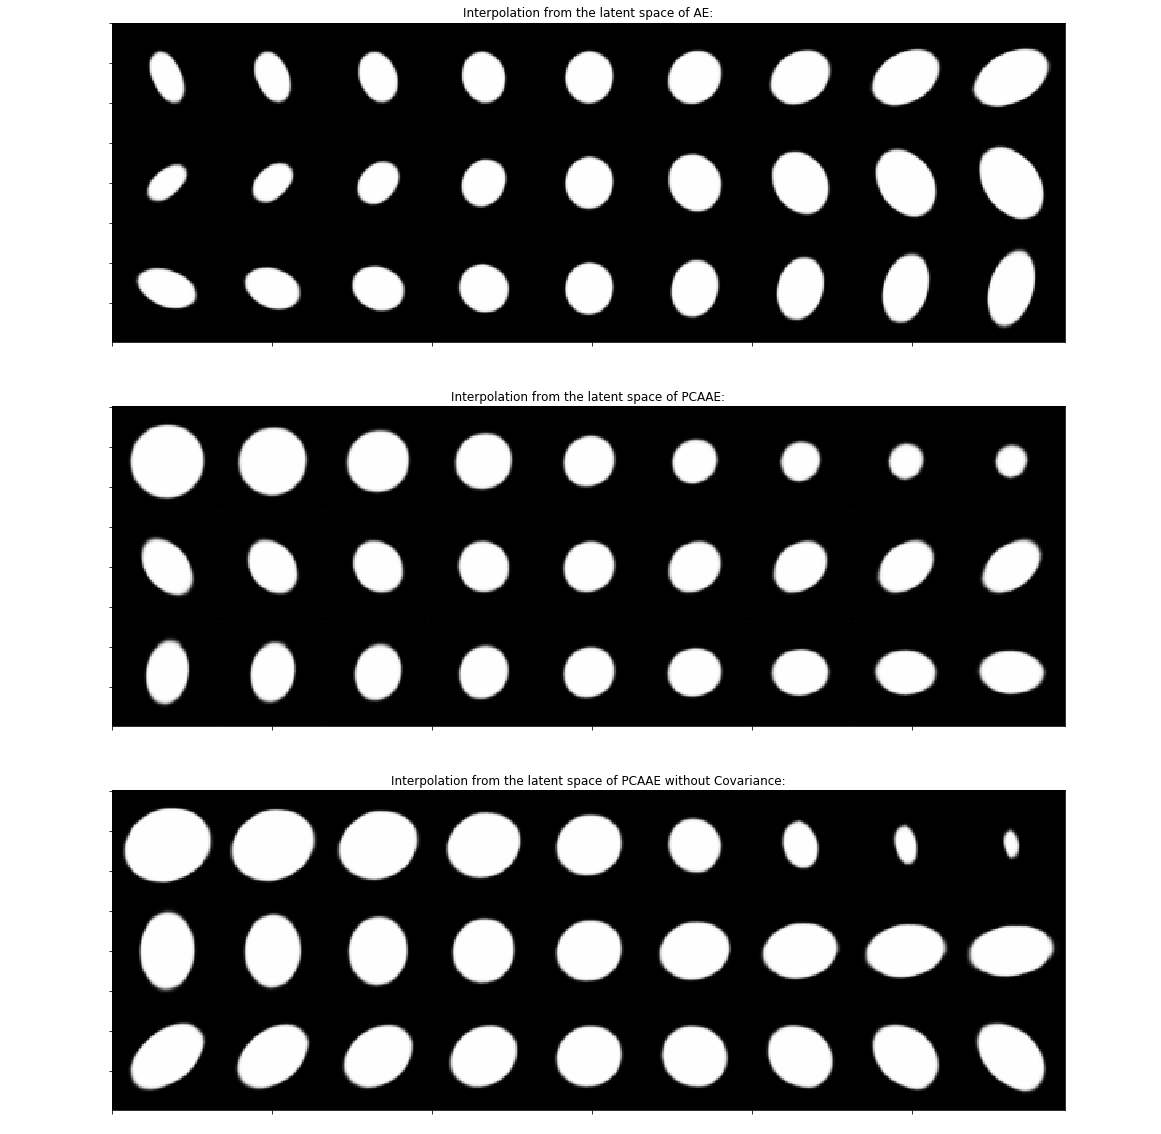

In [135]:
def test_model(model_D):
    z = torch.arange(-1,1.1,0.25).unsqueeze(1)
    length = len(z)
    z1_full = torch.cat((z,torch.zeros(length,1),torch.zeros(length,1)),dim=-1).to(device)
    z2_full = torch.cat((torch.zeros(length,1),z,torch.zeros(length,1)),dim=-1).to(device)
    z3_full = torch.cat((torch.zeros(length,1),torch.zeros(length,1),z),dim=-1).to(device)
    with torch.no_grad():
        recon_z1_AE = model_D(z1_full)
        recon_z2_AE = model_D(z2_full)
        recon_z3_AE = model_D(z3_full)
        recon_AE = torch.cat((recon_z1_AE,recon_z2_AE,recon_z3_AE), dim=0)
    return recon_AE
   
fig, ax = plt.subplots(figsize=(20,20))
ax.axis('off')

grid_AE = torchvision.utils.make_grid(test_model(AE_D).clamp(min=-1, max=1), nrow=9, scale_each=True, normalize=True).cpu().numpy()

ax1 = fig.add_subplot(3,1,1, xticklabels=[], yticklabels=[])
ax1.title.set_text("Interpolation from the latent space of AE:")
plt.imshow(grid_AE.transpose(1,2,0), cmap='gray')

grid_PCAAE = torchvision.utils.make_grid(test_model(PCAAE_D [train_latent-1]).clamp(min=-1, max=1),  nrow=9, scale_each=True, normalize=True).cpu().numpy()

ax2 = fig.add_subplot(3,1,2, xticklabels=[], yticklabels=[])
ax2.title.set_text("Interpolation from the latent space of PCAAE:")
plt.imshow(grid_PCAAE.transpose(1,2,0), cmap='gray')

grid_PCAAE_noCov = torchvision.utils.make_grid(test_model(PCAAE_D_noCov [train_latent-1]).clamp(min=-1, max=1),  nrow=9, scale_each=True, normalize=True).cpu().numpy()

ax3 = fig.add_subplot(3,1,3, xticklabels=[], yticklabels=[])
ax3.title.set_text("Interpolation from the latent space of PCAAE without Covariance:")
plt.imshow(grid_PCAAE_noCov.transpose(1,2,0), cmap='gray')

plt.show()

Then, we will use Pearson correlation coefficient to evaluate our models

In [136]:
def correlation(X1,X2):
        X1 = X1.squeeze()
        X2 = X2.squeeze()
        cov = ((X1-X1.mean())*(X2-X2.mean())).mean()
        cor = cov/(X1.std()*X2.std())
        return torch.abs(cor)
    
def evaluation(z,rect): 
    # Latent space 's composants
    z1 = z[:,0]
    z2 = z[:,1]
    z3 = z[:,2]

    # Ellipse area
    S = (rect).view(-1,64*64).sum(dim=-1,keepdims=True)
    # Horizontal axis
    L_1 = rect.squeeze()[:,31,:].sum(dim=-1,keepdims=True)
    # Vertical axis
    L_2 = rect.squeeze()[:,:,31].sum(dim=-1,keepdims=True)
    # Diagonal axis
    L_3 = torch.cat( [jd.squeeze().trace().unsqueeze(0) for jd in rect], dim=0).unsqueeze(1)
    # Another diagonal axis
    L_4 = torch.cat( [jd.squeeze().rot90().trace().unsqueeze(0) for jd in rect], dim=0).unsqueeze(1)
    
    # Horizontal/verical ratio
    H = torch.abs(L_1/L_2)
    # Two-diagonal-lines ratio
    V = torch.abs(L_3/L_4)
    
    # Correlations
    cor_S1 = correlation(z1,S)
    cor_S2 = correlation(z2,S)
    cor_S3 = correlation(z3,S)
     
    cor_H1 = correlation(z1,H)
    cor_H2 = correlation(z2,H)
    cor_H3 = correlation(z3,H)
    
    cor_V1 = correlation(z1,V)
    cor_V2 = correlation(z2,V)
    cor_V3 = correlation(z3,V)
    
    return ((cor_S1,cor_S2,cor_S3),(cor_H1,cor_H2,cor_H3),(cor_V1,cor_V2,cor_V3))

we compute the latent space

In [137]:
test_dataset = generating_data(1000,image_size=image_size,max_gray=max_gray,save_training_image=False,path_data=path_data)
test_dataset = torch.stack([torch.Tensor(i) for i in test_dataset])/ max_gray
test_dataset = test_dataset.to(device)
with torch.no_grad():
    z_AE = AE_E.eval()(test_dataset)
    
    z_PCAAE = torch.cat((PCAAE_E[0].eval()(test_dataset),
                         PCAAE_E[1].eval()(test_dataset),
                         PCAAE_E[2].eval()(test_dataset),),dim=-1)
    
    z_PCAAE_noCov = torch.cat((PCAAE_E_noCov[0].eval()(test_dataset),
                               PCAAE_E_noCov[1].eval()(test_dataset),
                               PCAAE_E_noCov[2].eval()(test_dataset),),dim=-1)

Now, we show the quantitative results

In [138]:
evaluation(z_AE, test_dataset)

((tensor(0.7089, device='cuda:0'),
  tensor(0.8482, device='cuda:0'),
  tensor(0.4849, device='cuda:0')),
 (tensor(0.3533, device='cuda:0'),
  tensor(0.2372, device='cuda:0'),
  tensor(0.7423, device='cuda:0')),
 (tensor(0.5443, device='cuda:0'),
  tensor(0.3212, device='cuda:0'),
  tensor(0.4788, device='cuda:0')))

In [139]:
evaluation(z_PCAAE, test_dataset)

((tensor(0.9740, device='cuda:0'),
  tensor(0.0112, device='cuda:0'),
  tensor(0.0483, device='cuda:0')),
 (tensor(0.0915, device='cuda:0'),
  tensor(0.1975, device='cuda:0'),
  tensor(0.8439, device='cuda:0')),
 (tensor(0.1253, device='cuda:0'),
  tensor(0.7575, device='cuda:0'),
  tensor(0.1811, device='cuda:0')))

In [140]:
evaluation(z_PCAAE_noCov, test_dataset)

((tensor(0.9210, device='cuda:0'),
  tensor(0.5402, device='cuda:0'),
  tensor(0.2898, device='cuda:0')),
 (tensor(0.0995, device='cuda:0'),
  tensor(0.7626, device='cuda:0'),
  tensor(0.0445, device='cuda:0')),
 (tensor(0.0946, device='cuda:0'),
  tensor(0.1371, device='cuda:0'),
  tensor(0.7389, device='cuda:0')))